This notebook includes my own personal implementation of a TensorFlow Convolutional Neural Network to recognize handwritten digits from the MNIST dataset. I also include some figures and notes that helped me understand the workings of the program. Along the way, I included some interesting visualizations of the data from the dataset and demonstrate the effectiveness of the network.

In [1]:
# Author: Frederick Schulze
# Sources: https://www.tensorflow.org/tutorials
# Notebook created: May 24, 2023
# Last updated: Mar 19, 2025
# Update Summary: Improved commenting and demonstrations at end of notebook.
# 1. Improved the functionality of the 10 random number tester.
# 2. Added a section to verify the total accuracy of the neural network model on the test dataset.
# 3. Added seaborn confusion plots.
# 4. Added summary of accuracies for each digit.
# 5. Added plot to show misidentified examples.

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

print("Modules successfully imported!")
print("Tensorflow version:", tf.__version__)

Modules successfully imported!
Tensorflow version: 2.18.0


In [3]:
# x is pixel grayscale values, y is labels
# Loads data from MNIST and automatically divides dataset into training and testing data, with labels
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
print("MNIST data successfully loaded!")
print("xTrain Shape: ", xTrain.shape)
print("yTrain Shape: ", yTrain.shape)
print("xTest Shape: ", xTest.shape)
print("yTest Shape: ", yTest.shape)
print(f"Training Dataset: {xTrain.shape[0]} training images with resolution: {xTrain.shape[1]} x {xTrain.shape[2]}")
print(f"Testing Dataset: {xTest.shape[0]} test images with resolution: {xTest.shape[1]} x {xTest.shape[2]}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MNIST data successfully loaded!
xTrain Shape:  (60000, 28, 28)
yTrain Shape:  (60000,)
xTest Shape:  (10000, 28, 28)
yTest Shape:  (10000,)
Training Dataset: 60000 training images with resolution: 28 x 28
Testing Dataset: 10000 test images with resolution: 28 x 28


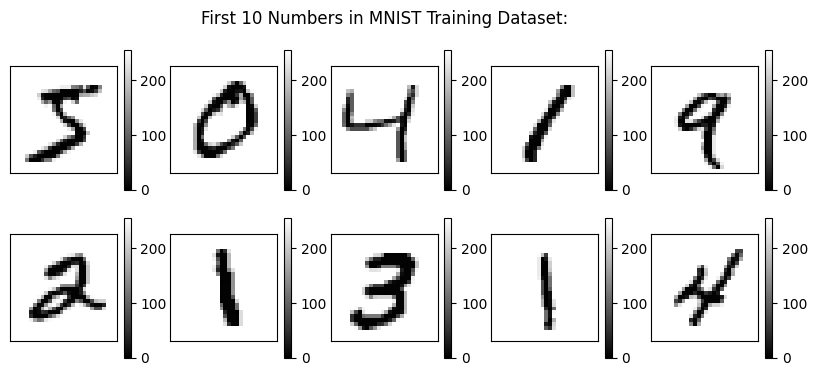

In [4]:
# Maybe these look better with colors inverted
# Showing the first 10 numbers in the dataset
xTrain_inverted = 255 - xTrain
plt.figure(figsize=(10,4))
plt.suptitle("First 10 Numbers in MNIST Training Dataset:")
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(xTrain_inverted[i], cmap='gray')
    plt.colorbar()

Values must be normalized from 0-255 (8-bit) to a float in range (0,1) because this is the standard input range for a neural network:

In [5]:
(xTrain, xTest) = (xTrain.astype('float32')/255.0, xTest.astype('float32')/255.0)
print(type(xTrain[0,0,0]))
xTrain.shape

<class 'numpy.float32'>


(60000, 28, 28)

xTrain and xTest must be expanded because this is a CNN. Conv2D requires a 3 dimensional input because it can receive batches of n images. In this case, it receives individual images where n=1, because we are using 1 grayscale image. A color image would be size (60000, 28, 28, 3) because of rgb values.

In [6]:
xTrain = np.expand_dims(xTrain, -1)
xTest = np.expand_dims(xTest, -1)
print("Now that dims are expanded:")
print(xTrain.shape)

Now that dims are expanded:
(60000, 28, 28, 1)


Now time to create the model using Keras:

In [7]:
#Note: Using input layer instead of "input size" parameter in Conv2D is the better approach

model = tf.keras.Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(10, activation="softmax"),
    ]
)

Time to use one-hot encoding:

In [8]:
# Using one-hot encoding:
# This converts the labels 0-9 to 1/0 encoded labels
# I.e. 5 converts to [0,0,0,0,0,1,0,0,0,0]
# This increases the rank of the matrix by one (expands dimension)
#   Size of the newest dimension = highest integer of previous
#
# One-hot encoding is needed for categorical_crossentropy, but this conversion isn't needed with spare_categorical_crossentropy (loss function mentioned below)
print("yTrain Before: ", yTrain[:10])
print(f"yTrain Shape: {yTrain.shape}\n")
yTrainCat = keras.utils.to_categorical(yTrain, 10)
yTestCat = keras.utils.to_categorical(yTest, 10)
print("Used keras.utils.to_categorical\n")
print("yTrainCat after: \n", yTrainCat[:10])
print(f"yTrainCat Shape: {yTrainCat.shape}")

yTrain Before:  [5 0 4 1 9 2 1 3 1 4]
yTrain Shape: (60000,)

Used keras.utils.to_categorical

yTrainCat after: 
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
yTrainCat Shape: (60000, 10)


In [9]:


batch_size = 128
epochs = 4


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(xTrain, yTrainCat, epochs=epochs, validation_split=0.1)

# Note on epoch and batch size:
# Default batch size is 32, which is why there are 1688 per epoch with no specification (54016/32)
# It would be 422 per epoch if batch size set to 128
# Batch size: How often the algorithm recaculates a gradient for the gradient descent algorithm
  # The gradient calculated using de/dw_i where it is the combination of weight changes in the direction reduces error fastest
# There are 1688*32 images trained per epoch, therefore 54016 total (actually since there's 54k there's 16 as a rounding error)

# Note on loss function:
# The default yTrain and yTest can be used with sparse_categorical_crossentropy.
# But it is more popular to use one-hot encoded values with categorical_crossentropy.

# Validation split: Split off a portion of the training dataset randomly to be used for validation.
  # With validation_split=0.1 the 60k images are separated to 54k training and 6k validation
  # This is to ensure that overfitting does not occur


Epoch 1/4
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8679 - loss: 0.4316 - val_accuracy: 0.9833 - val_loss: 0.0571
Epoch 2/4
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9770 - loss: 0.0780 - val_accuracy: 0.9875 - val_loss: 0.0468
Epoch 3/4
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9817 - loss: 0.0580 - val_accuracy: 0.9902 - val_loss: 0.0351
Epoch 4/4
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9851 - loss: 0.0455 - val_accuracy: 0.9888 - val_loss: 0.0400


In [10]:
# The probability model attempts to convert logits into probabilities using softmax.

probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

The below cell chooses 10 random images from the test dataset. Rerun this cell to pick 10 new random ones. The logit value format is displayed below. These values correspond to a perceived likelihood of the image being recognized as a certain number.

In [11]:
#Shows the format of the probability model
numImages = 10
startIndex = random.randint(0, xTest.shape[0]-numImages-1)
endIndex = startIndex + numImages
logitvals = probability_model(xTest[startIndex:endIndex])
print(f"Chosen Images #{startIndex}-{endIndex}\n")
logitvals

Chosen Images #1175-1185



<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0.08533788, 0.08534411, 0.08533794, 0.08533888, 0.08533791,
        0.08533789, 0.08533788, 0.23195122, 0.08533791, 0.08533835],
       [0.23191768, 0.08534754, 0.08534176, 0.08534002, 0.08534104,
        0.08534023, 0.08534078, 0.08534253, 0.08534834, 0.0853401 ],
       [0.08533724, 0.08533911, 0.23196135, 0.08533751, 0.08533724,
        0.08533724, 0.08533724, 0.08533847, 0.08533729, 0.08533724],
       [0.08731467, 0.08594308, 0.08604989, 0.08597101, 0.22216822,
        0.08596334, 0.08801997, 0.08594818, 0.08661147, 0.08601009],
       [0.08533841, 0.2319431 , 0.08533847, 0.08533841, 0.08534038,
        0.08533851, 0.0853387 , 0.08533899, 0.08534654, 0.0853385 ],
       [0.08533734, 0.23195985, 0.08533737, 0.08533738, 0.0853392 ,
        0.08533746, 0.08533768, 0.08533775, 0.08533861, 0.08533738],
       [0.08759272, 0.10971622, 0.08760649, 0.08759087, 0.08764993,
        0.08759097, 0.18916838, 0.08758748, 0.08790947, 0.08

Now I pick 10 random images from the test dataset and see if the Convolutional Neural Network model gets them right! Reload the cell as many times as you'd like to see more results. It should get them right about 99% of the time, so it can be hard to find incorrect cases.

And in my experience, most of the cases it gets wrong are understandably poor handwriting...

Chosen Images #1175-1185



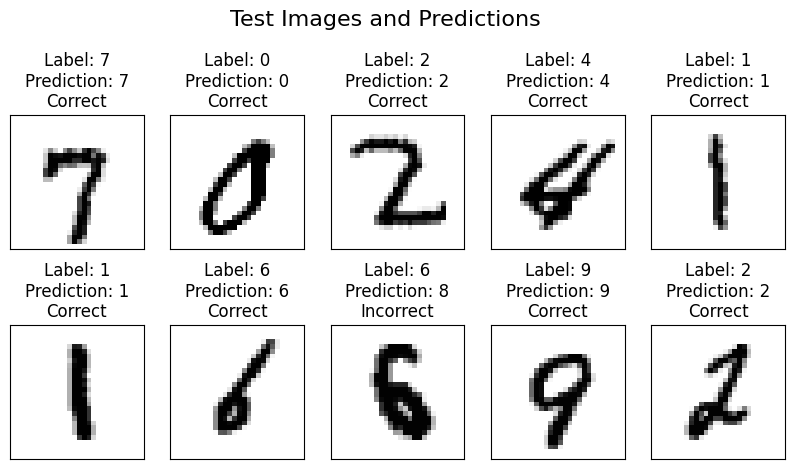

In [12]:
# Determining prediction based on the most likely estimate from logitvals
if "predictions" not in locals(): #If rerunning the cell, the numbers are "rerolled"
  predictions=[None]*10
  for i in range(0,10):
    predictions[i] = tf.argmax(logitvals[i])
else:
  numImages = 10
  startIndex = random.randint(0, xTest.shape[0]-numImages-1)
  endIndex = startIndex + numImages
  logitvals = probability_model(xTest[startIndex:endIndex])
  predictions=[None]*10
  for i in range(0,10):
    predictions[i] = tf.argmax(logitvals[i])

# Displaying with pyplot
xTest_inverted = 255-xTest
print(f"Chosen Images #{startIndex}-{endIndex}\n")
plt.figure(figsize=(10,5))
plt.suptitle("Test Images and Predictions", fontsize=16, y=1.05)
for i in range(numImages):
  plt.subplot(2,5,i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(xTest_inverted[startIndex+i], cmap='gray')
  #plt.colorbar() #turned off for now
  true_label = yTest[startIndex + i]
  prediction = predictions[i].numpy()
  result = "Correct" if true_label == prediction else "Incorrect"
  plt.title(f"Label: {true_label}\nPrediction: {prediction}\n{result}")



This was just some debugging to get the above plot working correctly

In [13]:
# Some testing to get the above plot working correctly
nextline_val = (len(predictions)+1)//2
print("Neural Network Predictions:")
for i,val in enumerate(predictions):
  if i==nextline_val: print()
  print(val.numpy(), end=" ")
print()
#
matches = yTest[startIndex:startIndex + numImages] == np.array(predictions)

# Reshape the matches into a 2x5 matrix for easier viewing
match_matrix = matches.reshape(2, 5)

# Print the match matrix

print("Match Matrix (True = match, False = mismatch):")
print(match_matrix)

Neural Network Predictions:
7 0 2 4 1 
1 6 8 9 2 
Match Matrix (True = match, False = mismatch):
[[ True  True  True  True  True]
 [ True  True False  True  True]]


**Performance Visualizations**  
After this point is just my exploration into how the model performs. I wanted to get an idea of the accuracy overall as well as the strong and weakpoints of the model.

In [14]:
#This is the automatic way to evaluate the model accurcay
test_loss, test_accuracy = model.evaluate(xTest, yTestCat)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# But I also wanted to calculate the accuracy manually to verify
yPred = model.predict(xTest)
yPredClasses = np.argmax(yPred, axis=1)
yTrueClasses = np.argmax(yTestCat, axis=1)
accuracy = np.sum(yPredClasses == yTrueClasses) / len(yTrueClasses) * 100
print(f"Accuracy of the model: {accuracy:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9843 - loss: 0.0444
Test Accuracy: 98.75%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy of the model: 98.75%


"plt.figure(figsize=(10, 7))\nsns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))\nplt.xlabel('Predicted Label')\nplt.ylabel('True Label')\nplt.title('Confusion Matrix')\nplt.show()"

The accuracy seems to always be in the 98.5-99% range, which is expected for a simple MNIST model. I'd say this is a success. With more train time and compute power, a more complicated model could probably do better.

The following code creates a matrix that shows predictions vs actual

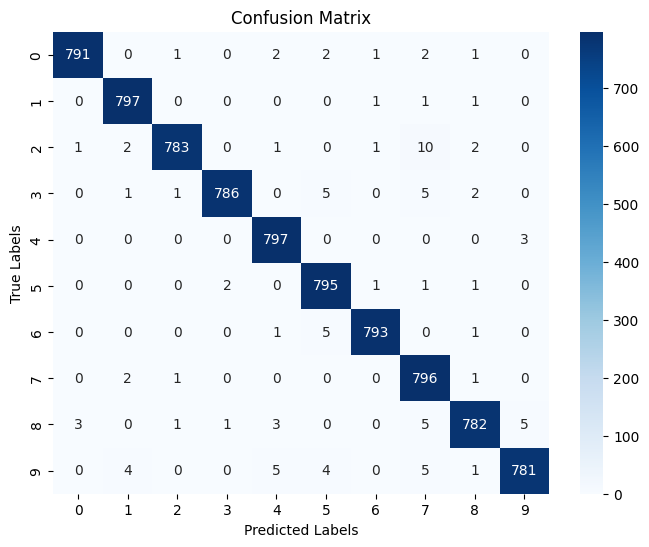

In [21]:
num_samples_per_class = 800 #Max number of samples of each actual label. For some reason, I couldn't do 1000 so I did this.

# Ensures equal distribution of each class
xTest_balanced = []
yTest_balanced = []

for label in range(10):
    class_indices = np.where(yTest == label)[0]
    selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    xTest_balanced.extend(xTest[selected_indices]) # this balances the distribution
    yTest_balanced.extend(yTest[selected_indices])

xTest_balanced = np.array(xTest_balanced)
yTest_balanced = np.array(yTest_balanced)

# Get the predictions for these balanced sets
logitvals = probability_model(xTest_balanced)
predictions = tf.argmax(logitvals, axis=1).numpy()

# Generate a confusion matrix using the Seaborn package
cm = confusion_matrix(yTest_balanced, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

This is good, but I wanted to remove the correct results to focus on the errors:

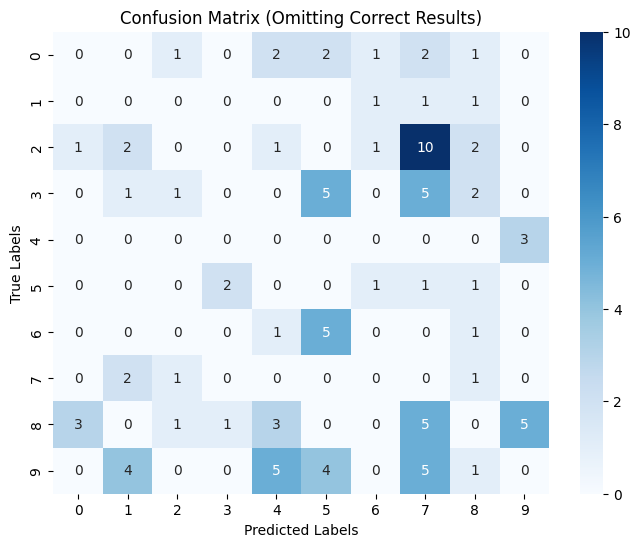

In [22]:
# Generate the confusion matrix but replacing the diagonal with 0s
cm = confusion_matrix(yTest_balanced, predictions)
np.fill_diagonal(cm, 0)

# Code for plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix (Omitting Correct Results)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The above confusion matrix varies a lot between runs, even with the same model architecture, training scheme, and same exact Python code. This demonstrates the randomness that exists in training these models. Which means that an ensemble model could have promising results. One run I had a model that misclassified quite a few 7's as 2's. In this commit (Mar 19, 2025), the model misclassifies a lot of 2's as 7's but not the other way around. Also, 9 gets confused with 4 and 4 with 9 a fair amount, which makes sense since they look similar.

This below code is just to create a more simplified accuracy table to see which numbers the model excels at and struggles with.

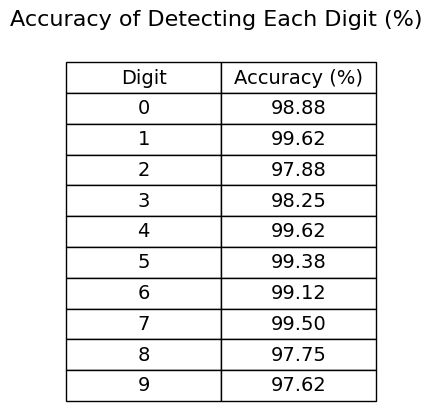

In [23]:
accuracies_list = []
for label in range(10):
    # summing instances where y_test_balanced = predictions = label
    correct_predictions = np.sum((yTest_balanced == label) & (predictions == label))
    total_label_count = np.sum(yTest_balanced == label)
    accuracy_label = (correct_predictions / total_label_count) * 100
    accuracies_list.append(accuracy)

accuracies_list = [round(acc, 2) for acc in accuracies_list]
formatted_accuracies = ["{:.2f}".format(acc) for acc in accuracies_list]

# Using DataFrame for the table feature
accuracy_table = pd.DataFrame({
    'Digit': range(10),
    'Accuracy (%)': formatted_accuracies
})

# Making the matplotlib figure from the table
fig, ax = plt.subplots(figsize=(4, 4))

ax.axis('auto')
ax.axis('off')

table = ax.table(cellText=accuracy_table.values, colLabels=accuracy_table.columns, loc='center', cellLoc='center')

# Fixing font size issues
table.set_fontsize(30)
for cell in table.get_celld().values():
    cell.set_height(0.1)

plt.suptitle("Accuracy of Detecting Each Digit (%)", fontsize=16, ha='center', va='top', y=1.05)
plt.show()

In this run, the numbers it struggles most with are 2, 8, and 9. However, in the past, the model has struggled with 7. Shows the variation that can happen in training. The important thing is that all of these are typically >97%, so the model at least does fairly well for every number.

Now I want to explore the examples where the model misclassified a 2 as a 7, since this was fairly common in the current iteration.

In [18]:
# Getting a fresh set of predictions
# using the full test pool again (not limited to 800)
logitvals = probability_model(xTest)
predictions_all = tf.argmax(logitvals, axis=-1)

Found 12 cases where 2 was misidentified as 7.


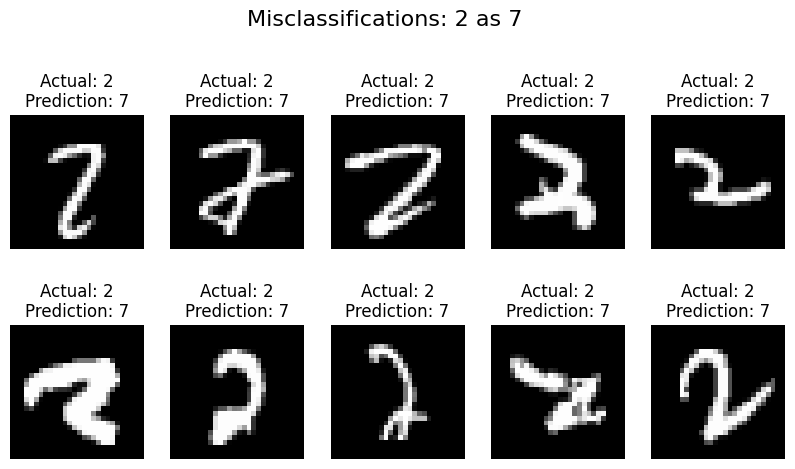

In [26]:
misidentified_2_as_7 = []

# Finds the indices where the true label is 7, but the predicted label is 2
misidentified_2_as_7 = []
for i in range(len(predictions_all)):
    if yTest[i] == 2 and predictions_all[i] == 7:
        misidentified_2_as_7.append(i)

# Ensuring the number is reasonable. I was getting over 80 due to a bug.
num_misidentified = len(misidentified_2_as_7)

if num_misidentified > 0:
    print(f"Found {num_misidentified} cases where 2 was misidentified as 7.")
    num_images_to_show = min(num_misidentified, 10)  # Shows at most 10 misidentified images

    # and the plot code; subplot handles up to 10 examples
    plt.figure(figsize=(10, 5))
    plt.suptitle("Misclassifications: 2 as 7", fontsize=16, y=1.05)
    for i in range(num_images_to_show):
        index = misidentified_2_as_7[i]
        plt.subplot(2, 5, i+1)
        plt.imshow(xTest[index].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"Actual: 2\nPrediction: 7") #this will be true for all, so it can be hardcoded

    plt.show()
else:
    print("No cases where 2 was misidentified as 7.") #very rare, but could happen

These are usually fun to look at. Most are pretty sloppy examples. Even I would probably classify some of these wrong.
